# Applying the rate based analysis to the spiking network

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import brian2 as b2
import attractor_network

## Getting the FF curves for the E and I neurons

Have the following populations, and feed in a 100 Hz input with different weights 
* excitatory neurons with pure excitatory input (0 to 1)
  * get the FF curve for excitatory neurons - tells us $\rho_E$ and $\theta_E$
* inhibitory neurons with pure excitatory input (0 to 1)
  * get the FF curve for inhibitory neurons - tells us $\rho_I$ and $\theta_I$
* excitatory neurons with excitatory and inhibitory inputs (0 to 8, because inhibitory synapses are about 8 times weaker)
  * find the amount of inhibition that balances excitation - get the relative strength of inhibitory neurons compared to excitatory

In [2]:
input_weights = np.arange(0, 1, 0.01)
input_weights_ei = 8*input_weights # need about 8 times stronger inhibition to cancel out excitation

network = b2.Network()
neuron_group_e = b2.NeuronGroup(len(input_weights), attractor_network.neuron_eqs_e, threshold='v>v_thresh_e', refractory='refrac_e', reset='v=v_reset_e', method='euler')
neuron_group_i = b2.NeuronGroup(len(input_weights), attractor_network.neuron_eqs_i, threshold='v>v_thresh_i', refractory='refrac_i', reset='v=v_reset_i', method='euler')
neuron_group_e_inh = b2.NeuronGroup(len(input_weights)**2, attractor_network.neuron_eqs_e, threshold='v>v_thresh_e', refractory='refrac_e', reset='v=v_reset_e', method='euler')
neuron_group_e.v = attractor_network.default_params['v_rest_e']
neuron_group_i.v = attractor_network.default_params['v_rest_i']
neuron_group_e_inh.v = attractor_network.default_params['v_rest_e']

neuron_group_input = b2.PoissonGroup(1, 100*b2.Hz)
input_connection_e = b2.Synapses(neuron_group_input, neuron_group_e, 'w : 1', on_pre='ge_post += w')
input_connection_i = b2.Synapses(neuron_group_input, neuron_group_i, 'w : 1', on_pre='ge_post += w')
input_connection_e_inh_e = b2.Synapses(neuron_group_input, neuron_group_e_inh, 'w : 1', on_pre='ge_post += w')
input_connection_e_inh_i = b2.Synapses(neuron_group_input, neuron_group_e_inh, 'w : 1', on_pre='gi_post += w')
input_connection_e.connect(True)
input_connection_i.connect(True)
input_connection_e_inh_e.connect(True)
input_connection_e_inh_i.connect(True)
input_connection_e.w = input_weights
input_connection_i.w = input_weights
input_connection_e_inh_e.w = np.tile(input_weights, (len(input_weights),1)).ravel()
input_connection_e_inh_i.w = np.tile(input_weights_ei, (len(input_weights),1)).T.ravel()

monitor_e = b2.SpikeMonitor(neuron_group_e)
monitor_i = b2.SpikeMonitor(neuron_group_i)
monitor_e_inh = b2.SpikeMonitor(neuron_group_e_inh)
monitor_input = monitor_input = b2.SpikeMonitor(neuron_group_input)

network.add([neuron_group_e, neuron_group_i, neuron_group_e_inh, neuron_group_input, input_connection_e, input_connection_i, input_connection_e_inh_e, input_connection_e_inh_i, monitor_e, monitor_i, monitor_e_inh, monitor_input])

network.store()

In [23]:
params = attractor_network.default_params.copy()

params['sigma_noise_e'] = 0*b2.mV # remove the noise to make the FF curve clearer
params['sigma_noise_i'] = 0*b2.mV
params['g_mem_e'] = 0.4*b2.nS # make this lower so the excitatory neurons respond at a lower input

duration = 2000*b2.ms
network.restore()
network.run(duration, namespace=params)

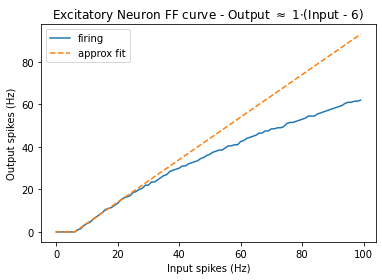

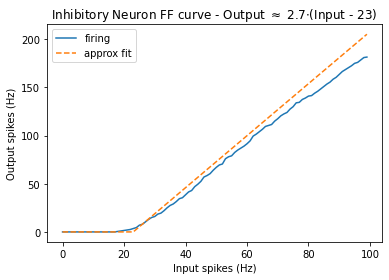

In [26]:
# fit RELU functions to the FF curves

rates_E = np.zeros(len(input_weights))
rates_I = np.zeros(len(input_weights))
index, count = np.unique(monitor_e.i[:], return_counts=True)
rates_E[index] = count/duration
index, count = np.unique(monitor_i.i[:], return_counts=True)
rates_I[index] = count/duration

relu = lambda x: np.maximum(0,x)
theta_E = 6
theta_I = 23
rho_E = 1
rho_I = 2.7

plt.plot(input_weights*100*b2.Hz, rates_E, label='firing')
plt.plot(input_weights*100*b2.Hz, rho_E*relu(input_weights*100*b2.Hz - theta_E*b2.Hz), '--', label='approx fit')
plt.ylabel('Output spikes (Hz)')
plt.xlabel('Input spikes (Hz)')
plt.title(fr'Excitatory Neuron FF curve - Output $\approx$ {rho_E}$\cdot($Input - {theta_E}$)$')
plt.legend()
plt.show()
plt.plot(input_weights*100*b2.Hz, rates_I, label='firing')
plt.plot(input_weights*100*b2.Hz, rho_I*relu(input_weights*100*b2.Hz - theta_I*b2.Hz), '--', label='approx fit')
plt.ylabel('Output spikes (Hz)')
plt.xlabel('Input spikes (Hz)')
plt.title(fr'Inhibitory Neuron FF curve - Output $\approx$ {rho_I}$\cdot($Input - {theta_I}$)$')
plt.legend()
plt.show()

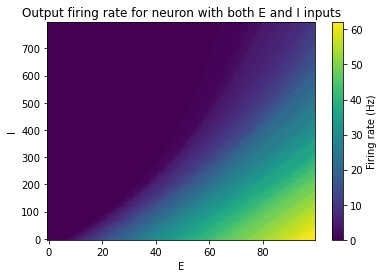

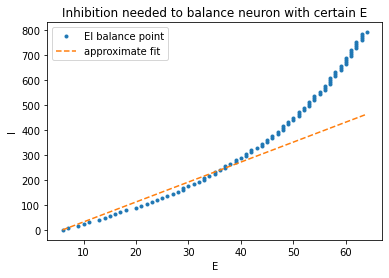

In [28]:
# check what balance of excitation and inhibition gives us ~0 firing
# ie. how strong is excitation relative to inhibition, because of the difference in synaptic parameters
rates_EI = np.zeros(len(input_weights)**2)
index, count = np.unique(monitor_e_inh.i[:], return_counts=True)
rates_EI[index] = count/duration

plt.pcolor(input_weights*100*b2.Hz, input_weights_ei*100*b2.Hz, np.reshape(rates_EI, (len(input_weights), len(input_weights))))
plt.xlabel('E')
plt.ylabel('I')
plt.colorbar().set_label('Firing rate (Hz)')
plt.title('Output firing rate for neuron with both E and I inputs')
plt.show()

A = np.reshape(rates_EI, (len(input_weights), len(input_weights)))
thresh = 0
inhibition_gain_factor = 8
excitation_no_firing = 100*b2.Hz*input_weights[np.argwhere(np.logical_and(A[:,:-1] <= thresh, A[:,1:] > thresh))[:,1]]
plt.plot(excitation_no_firing, 100*b2.Hz*input_weights_ei, '.', label='EI balance point')
plt.plot(excitation_no_firing, inhibition_gain_factor*(excitation_no_firing - excitation_no_firing[0]), '--', label='approximate fit')
plt.xlabel('E')
plt.ylabel('I')
plt.legend()
plt.title('Inhibition needed to balance neuron with certain E')
plt.show()

This tells us that we need ~8 times as much inhibition as excitation to balance the neuron not to fire - so we should multiply the I->E weight by about 8

## Setting up the network with the derived weight matrix

Given we know the FF responses of the E and I neurons, we can derive the weight matrix that should give us a stable sinusoidal activity bump at a certain amplitude.

In this case we aim for a sinusoid with a peak of 100 Hz.

In [29]:
N = 8
B = 2/N + 0.02
# target max firing rate of 100 Hz - convert this to a target amplitude of internal voltage, assuming A ~= v_mean
r_target = 100
A_target = 1/2 * (r_target/rho_E + theta_E)

v_mean = A_target*(1 - (((np.pi/(np.sqrt(2)*N) * (N/2 - 1/(rho_E*B)))**2)**(1/3))) + theta_E
w_mean = (v_mean + rho_I*(v_mean-theta_I)) / (rho_E*N*(v_mean-theta_E) + A_target*(rho_E*N/2 - 1/B))

print(f'A_target = {A_target:.4f}, v_mean = {v_mean:.4f}, w_mean = {w_mean:.4f}')

A_target = 53.0000, v_mean = 48.9741, w_mean = 0.3313


Here we do a quick check that the first fixed point for the mean voltage is unstable (under the inhibition threshold) and the second is stable (above the inhibition threshold). This seems to be a necessary (but not sufficient) condition for the network to have stable sinusoidal activity.

In [30]:
print(f'Linear region v_mean fixed points:\nv1={(rho_E*N*w_mean*theta_E) / (-1 + rho_E*N*w_mean):.3f}, v2={(rho_E*N*w_mean*theta_E - rho_I*theta_I) / (-1 + rho_E*N*w_mean - rho_I):.3f}')
print(f'v1 should be unstable if dv1 > 0 (dv1={-1 + rho_E*N*w_mean:.3f})\nv2 should be stable if dv2 < 0 (dv2={-1 + rho_E*N*w_mean - rho_I:.3f})\n')

delta = 1/(2*np.pi/N) * np.arccos((v_mean - theta_E) / A_target)
print(f'delta should be small to minimise the small angle approx error\ndelta={delta:.4f}, error = {100*abs(np.sin(2*np.pi/N*delta)-2*np.pi/N*delta)/np.sin(2*np.pi/N*delta):.2f}%\n')

print(f'Nonlinear region')# v_mean fixed points:\nv1={(rho_E*N*w_mean*theta_E - 2*rho_E*w_mean*delta*theta_E - 2*rho_E*A_target*w_mean*delta) / (-1 + rho_E*N*w_mean + 2*rho_E*w_mean*delta):.3f}, v2={(rho_E*N*w_mean*theta_E - 2*rho_E*w_mean*delta*theta_E - 2*rho_E*A_target*w_mean*delta - rho_I*theta_I) / (-1 + rho_E*N*w_mean + 2*rho_E*w_mean*delta - rho_I):.3f}')
print(f'v1 should be unstable if dv1 > 0 (dv1={-1 + rho_E*N*w_mean + 2*rho_E*w_mean*delta:.3f})\nv2 should be stable if dv2 < 0 (dv2={-1 + rho_E*N*w_mean + 2*rho_E*w_mean*delta - rho_I:.3f})')

Linear region v_mean fixed points:
v1=9.635, v2=44.017
v1 should be unstable if dv1 > 0 (dv1=1.650)
v2 should be stable if dv2 < 0 (dv2=-1.050)

delta should be small to minimise the small angle approx error
delta=0.7961, error = 6.82%

Nonlinear region
v1 should be unstable if dv1 > 0 (dv1=2.178)
v2 should be stable if dv2 < 0 (dv2=-0.522)


In [31]:
cosine = lambda amp, T, phase: lambda x: amp*(np.cos(2*np.pi*(x - phase)/T))
relu = lambda x: np.maximum(0,x)
sigmoid_E = lambda x: rho_E*relu(x - theta_E)
sigmoid_I = lambda x: rho_I*relu(x - theta_I)
def circ_wrapped_distance(x:np.ndarray, wrapping_boundary:float=2*np.pi):
	return wrapping_boundary/2 - np.abs(np.abs(x) - wrapping_boundary/2)
	
fw = lambda x: cosine(B,N,0)(x) + w_mean
t = np.arange(0,N,0.5)

d = circ_wrapped_distance(np.atleast_2d(t).T - t, N)
w = (t[1]-t[0]) * fw(d)

In [32]:
dt = 0.02
def simulate(v_init, num_timesteps: int):
	trajectory = np.zeros((num_timesteps,len(v_init)))
	trajectory[0] = v_init.copy()
	for t in range(1,num_timesteps):
		v = trajectory[t-1]
		v_dot = (-v + w@sigmoid_E(v) - sigmoid_I(v.mean()))*dt
		trajectory[t] = v + v_dot
		if abs(v_dot).sum() < 1e-7:
			trajectory[t:,:] = trajectory[t]
			break
	return trajectory

In [33]:
# get the flow field

v_mean_range = np.linspace(0,200,20)
A_range = np.linspace(0,200,20)

v_mean_dots = np.zeros((len(v_mean_range),len(A_range)))
A_dots = np.zeros((len(v_mean_range),len(A_range)))

for v_n,v_bar in enumerate(v_mean_range):
	for A_n, A in enumerate(A_range):
		if v_bar - A >= theta_E:
			A_dot = -A + rho_E*A*B/(2/N)
			v_bar_dot = -v_bar + rho_E*w_mean*N*(v_bar-theta_E) - rho_I*relu(v_bar - theta_I)
		else:
			delta = 1/(2*np.pi/N) * np.arccos((v_bar - theta_E) / A)
			A_dot = -A + rho_E*A*B/(2/N) + rho_E*B/(np.pi/N)*(v_bar-theta_E)*np.sin(2*np.pi/N*delta) - rho_E*A*B/(4*np.pi/N)*(4*np.pi/N*delta + np.sin(4*np.pi/N*delta))
			v_bar_dot = -v_bar + rho_E*w_mean*N*(v_bar-theta_E) - rho_I*relu(v_bar - theta_I) + 2*rho_E*delta*w_mean*(A - (v_bar-theta_E))
		v_mean_dots[v_n,A_n] = v_bar_dot
		A_dots[v_n,A_n] = A_dot

WARNING    C:\Users\Dominic\AppData\Local\Temp\ipykernel_37928\3109413807.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  delta = 1/(2*np.pi/N) * np.arccos((v_bar - theta_E) / A)
 [py.warnings]
WARNING    C:\Users\Dominic\AppData\Local\Temp\ipykernel_37928\3109413807.py:15: RuntimeWarning: invalid value encountered in arccos
  delta = 1/(2*np.pi/N) * np.arccos((v_bar - theta_E) / A)
 [py.warnings]


Now we can plot the phase space for this network and an example trajectory from a certain initialisation.

The network converges to a stable state which isn't quite what we predicted (presumably due to small angle approximation errors), but it's close

v_mean = 49.7900, A = 58.9749


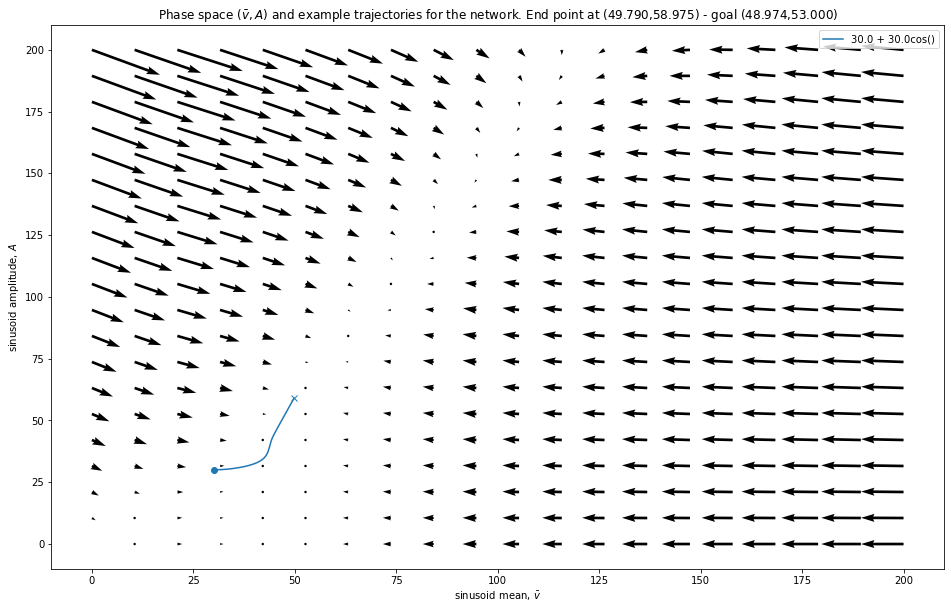

In [38]:
half_amplitude = lambda x: 0.5*(x.max() - x.min())

# v_sample = [1.5 + 0.1*cosine(1, N, 4)(t), 1.5 + 1.5*cosine(1, N, 4)(t), 1.5 + 2*cosine(1, N, 4)(t), 1.5 + 3*cosine(1, N, 4)(t), 3 + 0.1*cosine(1, N, 4)(t), 3 + 1.5*cosine(1, N, 4)(t), 3 + 2*cosine(1, N, 4)(t), 3 + 3*cosine(1, N, 4)(t), 1.8 + 0.5*cosine(1, N, 4)(t), 1.85 + 0.5*cosine(1, N, 4)(t)]
v_sample = [30 + 30*cosine(1, N, 4)(t)]
# v_sample = []

plt.figure(figsize=(16,10))
plt.quiver(v_mean_range, A_range, v_mean_dots.T, A_dots.T)
plt.xlabel(r'sinusoid mean, $\bar v$')
plt.ylabel(r'sinusoid amplitude, $A$')

for i, v_in in enumerate(v_sample):
	trajectory = simulate(v_in, 20000)
	c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i]
	plt.plot(np.mean(trajectory, axis=1), 0.5*abs(np.max(trajectory, axis=1) - np.min(trajectory, axis=1)), label=f'{v_in.mean()} + {(v_in.max()-v_in.min())/2:.1f}cos()', color=c)
	plt.plot(np.mean(trajectory[0]), half_amplitude(trajectory[0]), 'o', color=c)
	plt.plot(np.mean(trajectory[-1]), half_amplitude(trajectory[-1]), 'x', color=c)

print(f'v_mean = {np.mean(x := simulate(v_sample[-1], 20000)[-1]):.4f}, A = {half_amplitude(x):.4f}')

# plt.plot(v_mean_range[v_mean_range >= theta_E], v_mean_range[v_mean_range >= theta_E] - theta_E, '--')

plt.title(rf'Phase space ($\bar v, A$) and example trajectories for the network. End point at ({np.mean(x := simulate(v_sample[-1], 20000)[-1]):.3f},{half_amplitude(x):.3f}) - goal ({v_mean:.3f},{A_target:.3f})')
plt.legend()
plt.show()

Given the actual stable point of this rate-based network, we can look at the actual output firing rate (because the above is for the internal state variable of the neurons).

We get a not-quite sinusoidal shape with roughly 100 Hz firing rate, as we wanted.

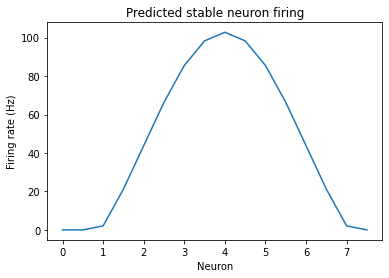

In [39]:
# the firing rate we expect to see coming from this model
end_point = simulate(v_sample[-1], 20000)[-1]
plt.plot(t, sigmoid_E(np.mean(end_point) + half_amplitude(end_point)*cosine(1, N, 4)(t)))
plt.xlabel('Neuron')
plt.ylabel('Firing rate (Hz)')
plt.title('Predicted stable neuron firing')
plt.show()

## Applying the calculated weight matrix to a spiking network

Now we have the analytically calculated weight matrix, we can apply it to a spiking network and see how well it performs. This weight matrix is for the EE connections. For the other connections we use:

* an EI weight of $1/N$ to make the inhibitory neurons' input equal to $\bar v$
* IE weight is 8 (equivalent to an excitatory weight of 1)
* II weight is 0

In [40]:
N = 8
network = attractor_network.AttractorNetwork(N, N)
network.default_params['g_mem_e'] = 0.4*b2.nS
network.default_params['weight_ii'] = 0
network.default_params['weight_ei'] = 1/N
network.default_params['weight_ie'] = inhibition_gain_factor

cosine = lambda amp, T, phase: lambda x: amp*(np.cos(2*np.pi*(x - phase)/T))
def circ_wrapped_distance(x:np.ndarray, wrapping_boundary:float=2*np.pi):
	return wrapping_boundary/2 - np.abs(np.abs(x) - wrapping_boundary/2)
t = np.arange(N)
d = circ_wrapped_distance(np.atleast_2d(t).T - t, N)
w = cosine(B,N,0)(d) + w_mean

warm_up_duration = 100*b2.ms
duration = 400*b2.ms

In [41]:
from typing import Callable, Any, List, Tuple

def get_network_results(network: attractor_network.AttractorNetwork, loss: Callable[[np.ndarray,np.ndarray,np.ndarray],Tuple[np.ndarray,float]]):
	response_start = network.monitor_e.i[:][np.logical_and(warm_up_duration<= network.monitor_e.t, network.monitor_e.t < warm_up_duration+duration/2)]
	response_end = network.monitor_e.i[:][network.monitor_e.t >= warm_up_duration+duration/2]
	indices_start, counts_start = np.unique(response_start, return_counts=True)
	indices_end, counts_end = np.unique(response_end, return_counts=True)
	full_indices_start, full_rates_start = hist_counts_to_full(indices_start, counts_start/(duration/2), np.arange(network.num_excitatory))
	full_indices_end, full_rates_end = hist_counts_to_full(indices_end, counts_end/(duration/2), np.arange(network.num_excitatory))
	best_fit, rms = loss(full_indices_start, full_rates_start, full_rates_end)
	return full_indices_start, full_rates_start, full_rates_end, best_fit, rms

def hist_counts_to_full(indices, counts, full_range):
	full_counts = np.zeros_like(full_range)
	full_counts[indices] = counts
	return full_range, full_counts

def circ_wrapped_distance(x:np.ndarray, wrapping_boundary:float=2*np.pi):
	return wrapping_boundary/2 - np.abs(np.abs(x) - wrapping_boundary/2)

def circ_sin(x:np.ndarray, mean, width=270):
	distance = 2*np.pi/x.shape[0] * (360/width) * circ_wrapped_distance(x-mean, x.shape[0])
	sin = 1/2*(1 + np.cos(distance))
	sin[abs(distance) > np.pi] = 0
	return sin

def response_rms_error(indices, rates, target):
	full_rates = np.zeros_like(target)
	full_rates[indices] = rates
	return np.sqrt(np.mean((full_rates - target)**2))

def get_rms_and_best(target_rates, rates1, rates2):
	rms = np.sqrt((np.mean((target_rates - np.atleast_2d(rates1).T)**2, axis=0)) + np.mean((target_rates - np.atleast_2d(rates2).T)**2, axis=0)/2)
	best_index = np.argmin(rms)
	return target_rates[:,best_index], rms[best_index]

def get_best_sinusoid_rms(indices, rates1, rates2, peak=100, width=270):
	mean_range = np.atleast_2d(np.arange(0, len(indices), 0.01))
	sinusoid_rates = peak * circ_sin(np.tile(np.atleast_2d(indices).T, (1,len(mean_range))), mean_range, width)
	return get_rms_and_best(sinusoid_rates, rates1, rates2)

def windowed_spike_rates(times, indices, duration:int, max_index: int, window_size:int):
	# split the indices array based on the times, with bins depending on window_size
	indices_bins = np.split(indices, np.sum(np.atleast_2d(times) < np.atleast_2d(np.arange(window_size,duration,window_size)).T, axis=1))
	means_peaks_angles =np.array([bump_population_vector_readout(hist_counts_to_full(*np.unique(indices_array, return_counts=True), np.arange(network.num_excitatory))[1]) for indices_array in indices_bins])
	return means_peaks_angles[:,0], means_peaks_angles[:,1], means_peaks_angles[:,2]

def bump_population_vector_readout(rates):
	"""Takes the firing rates for each neuron, distributed around a circle and calculates the mean angle and standard deviation."""
	angles = np.linspace(0, 2*np.pi, len(rates)+1)[:-1]
	mean_x = np.mean(rates*np.cos(angles))
	mean_y = np.mean(rates*np.sin(angles))
	mean_angle = np.arctan2(mean_y, mean_x)
	peak = np.sqrt(mean_x**2 + mean_y**2)
	# treat each spike as a sample
	standard_deviation = np.sqrt(np.sum(rates*circ_wrapped_distance(angles-mean_angle)**2) / np.sum(rates))
	return mean_angle, peak, standard_deviation

def plot_response(network, loss, show=True):
	indices, rates_start, rates_end, best_fit, rms = get_network_results(network, loss)
	# pop_mean, pop_peak, pop_stddev = bump_population_vector_readout(rates)
	window_duration=100
	means, _, angles = windowed_spike_rates(network.monitor_e.t/b2.ms, network.monitor_e.i[:], int((warm_up_duration+duration)/b2.ms), network.num_inhibitory, window_duration)
	neuron_means = (means % (2*np.pi))/2/np.pi*network.num_excitatory
	neuron_angles = angles/2/np.pi*network.num_excitatory

	fig, axs = plt.subplots(3, 1, figsize=(12,4), sharex=True)
	assert(isinstance(axs, np.ndarray))
	axs[0].plot(network.monitor_e.t/b2.ms, network.monitor_e.i[:], '.b')
	popvec_time = window_duration/2+np.arange(0,int((warm_up_duration+duration)/b2.ms),window_duration)
	axs[0].fill_between(popvec_time, neuron_means-neuron_angles, neuron_means+neuron_angles, alpha=0.2, color='lime')
	axs[0].set_ylabel('Neuron index')
	axs[0].set_ylim([0,network.num_excitatory])
	axs[0].set_title('E spikes')
	axs[1].plot(network.monitor_i.t/b2.ms, network.monitor_i.i[:], '.r')
	axs[1].set_ylabel('Neuron index')
	axs[1].set_title('I spikes')
	axs[2].plot(network.monitor_input.t/b2.ms, network.monitor_input.i[:], '.k')
	axs[2].set_xlabel('Time (ms)')
	axs[2].set_ylabel('Neuron index')
	axs[2].set_title('Input spikes')
	plt.tight_layout()

	fig, ax = plt.subplots(1,1)
	ax.set_title('Self-sustained spike rates')
	ax.set_xlabel('Neuron index')
	ax.set_ylabel('Firing Rate (Hz)')
	# ax.set_xlim([0,network.num_excitatory-1])
	ax.bar(indices, rates_start, align='edge', width=-0.3, label='actual firing first half')
	ax.bar(indices, rates_end, align='edge', width=0.3, label='actual firing second half')
	ax.plot(np.arange(network.num_excitatory), best_fit, 'k.-', label='target')
	plt.legend()
	# ax.plot(pop_peak*circ_gaussian(indices, pop_mean*network.num_excitatory/2/np.pi, pop_stddev*network.num_excitatory/2/np.pi, False), 'r')
	ax.set_title(f'Self-sustained spike rates\nerror={rms:.3f}')
	if show:
		plt.show()

Simulate the network with this weight matrix and plot the response

The amount of recurrent firing is slightly less than desired but quite OK. But the bump's position in the network isn't really stable

In [42]:
network.reset()
network.set_EE_connectivity(w)
network.run_with_inputs(warm_up_duration, [200*b2.Hz if 3<=i<=5 else 20*b2.Hz for i in range(network.num_excitatory)])
network.run_with_inputs(duration, 0)

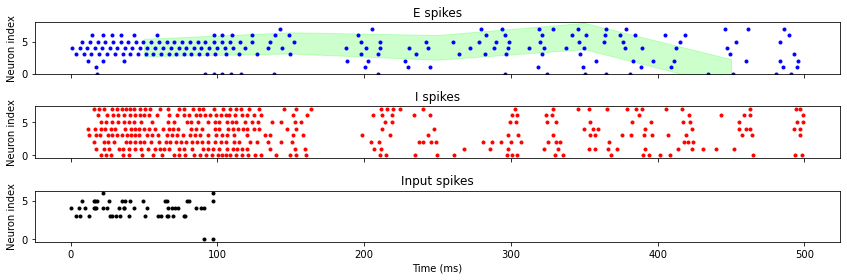

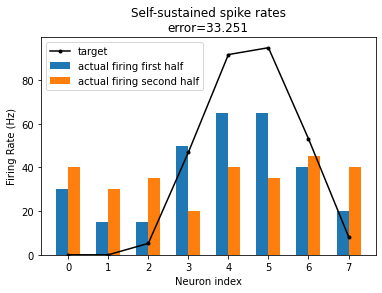

In [43]:
plot_response(network, get_best_sinusoid_rms)

If we provide a small input to a few neurons to keep the bump centred, then things look quite OK

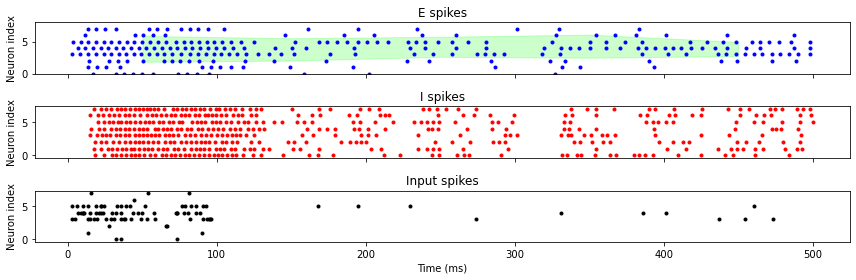

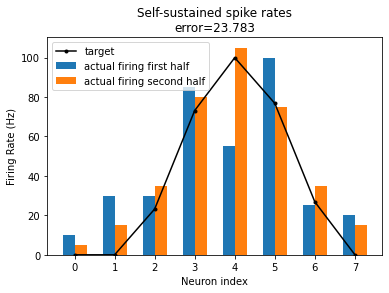

In [44]:
network.reset()
network.set_EE_connectivity(w)
network.run_with_inputs(warm_up_duration, [200*b2.Hz if 3<=i<=5 else 20*b2.Hz for i in range(network.num_excitatory)])
network.run_with_inputs(duration, [20*b2.Hz if 3<=i<=5 else 0*b2.Hz for i in range(network.num_excitatory)])
plot_response(network, get_best_sinusoid_rms)

## Running optimisation using the analytically derived weight matrix as the starting point

We specify the sinusoidal weight matrix in terms of a symmetrical distance-based connectivity kernel. Basically giving the connection strength between two neurons based on the shortest distance between them around the ring. This gives the optimisation routine more freedom to choose any symmetric connectivity kernel.

In [46]:
def run_network(network: attractor_network.AttractorNetwork, params: dict):
	network_params = {name : value for name,value in params.items() if not name.startswith('dist')}
	ee_connectivity_profile = np.array([value for name,value in params.items() if name.startswith('dist')])
	
	network.reset()
	network.params.update(network_params)
	network.circular_distance_EE_connectivity(ee_connectivity_profile)
	network.run_with_inputs(warm_up_duration, [200*b2.Hz if 3<=i<=5 else 20*b2.Hz for i in range(network.num_excitatory)])
	network.run_with_inputs(duration, 0)

params_to_tune = {
	'dist0': (0, 20, w[0,0], 1),
	'dist1': (0, 20, w[0,1], 1),
	'dist2': (0, 20, w[0,2], 1),
	'dist3': (0, 20, w[0,3], 1),
	'dist4': (0, 20, w[0,4], 1),
	# we fix the EI, IE, and II weights
	# 'weight_ei': (0, 5, 1/N, 1),
	# 'weight_ie': (0, 10, 8, 1),
}

def run_get_loss(params, loss):
	params_dict = {name : value*unit for (name, (_,_,_,unit)),value in zip(params_to_tune.items(), params)}
	run_network(network, params_dict)
	_, _, _, _, error = get_network_results(network, loss)

	return error

x0 = [p[2] for p in params_to_tune.values()]
bounds = [p[:2] for p in params_to_tune.values()]

# return function that takes a value between 0 and 1 and outputs a value in the range
param_scaler = lambda min,max : lambda x: min+x*(max-min)
param_scaler_nonnegative = lambda min,max : lambda x: min+x**2*(max-min)
param_unscaler_nonnegative = lambda min,max : lambda x: np.sqrt((x-min)/(max-min))

param_scalers = [param_scaler_nonnegative(*bound) for bound in bounds]
param_unscalers = [param_unscaler_nonnegative(*bound) for bound in bounds]

scale_params = lambda x: [scaler(param) for scaler,param in zip(param_scalers, x)]
unscale_params = lambda x: [scaler(param) for scaler,param in zip(param_unscalers, x)]

# return a function that wraps run_get_loss, so that CMA can learn params in the range 0-1 but these are 
# transformed to the ranges we want for the simulation
# returns a function that takes x, calls run_get_loss(transform_params(x))
def simulation_param_wrapper(loss):
	return lambda x: run_get_loss(scale_params(x), loss)

Running it before optimisation, we get a similar output to before

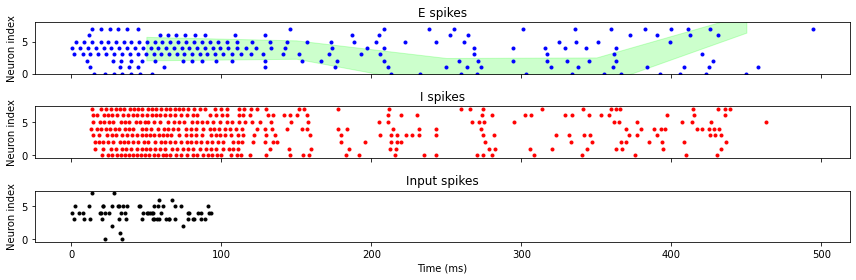

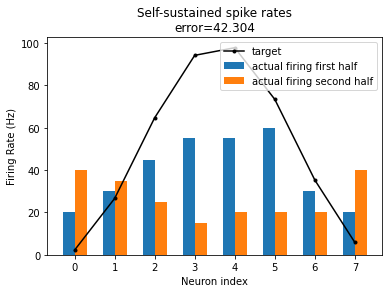

In [50]:
run_get_loss(x0, lambda indices, rates1, rates2: get_best_sinusoid_rms(indices, rates1, rates2, 100, 360))
plot_response(network, lambda indices, rates1, rates2: get_best_sinusoid_rms(indices, rates1, rates2, 100, 360))

In [51]:
import cma
x_best, cma_results = cma.fmin2(simulation_param_wrapper(lambda indices, rates1, rates2: get_best_sinusoid_rms(indices, rates1, rates2, 100, 360)), unscale_params(x0), 0.05, options={'ftarget': 5, 'maxfevals': 100})

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=694947, Tue Sep 20 00:46:43 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 3.102326338872409e+01 1.0e+00 4.76e-02  5e-02  5e-02 0:11.1
    2     16 3.186648086878368e+01 1.2e+00 4.41e-02  4e-02  5e-02 0:21.6
    3     24 2.717741216615964e+01 1.4e+00 4.22e-02  4e-02  4e-02 0:32.3
    4     32 1.872626931961520e+01 1.6e+00 3.91e-02  3e-02  4e-02 0:50.3
    5     40 1.450977971802873e+01 2.0e+00 4.18e-02  3e-02  5e-02 1:00.5
    6     48 1.150364788521788e+01 2.0e+00 3.83e-02  3e-02  4e-02 1:10.4
    7     56 1.216883171417925e+01 2.1e+00 3.30e-02  2e-02  4e-02 1:22.2
    8     64 1.499796732945951e+01 2.0e+00 3.25e-02  2e-02  4e-02 1:33.0
    9     72 1.125604133083558e+01 2.1e+00 2.56e-02  2e-02  3e-02 1:42.7
   10     80 1.714187351945674e+01 1.9e+00 2.53e-02  2e-02  2e-02 1:52.7
   11     88 1.891567122098298e+01 2.0e+00 2.41e-02  1e-02  2e-02 2:02.7
   13    104 1.622532821389289e+01 

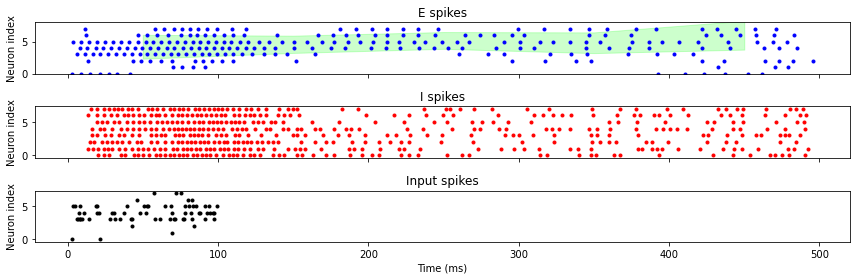

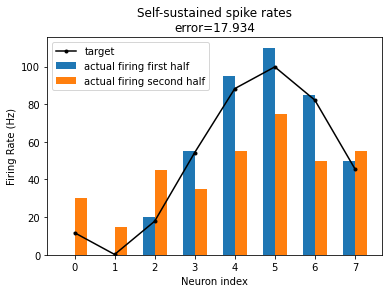

In [53]:
run_get_loss(scale_params(x_best), lambda indices, rates1, rates2: get_best_sinusoid_rms(indices, rates1, rates2, 100, 360))
plot_response(network, lambda indices, rates1, rates2: get_best_sinusoid_rms(indices, rates1, rates2, 100, 360))

Running the network after some optimisation, the bump's position around the ring still isn't very stable, but the shape of the bump is nicer than before optimisation